In [ ]:
!pip install ultralytics &> /dev/null

In [ ]:
# from google.colab import drive
import io
import pandas as pd
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
import os
import zipfile
import shutil

import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
# from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
# from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing import image
from PIL import Image
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from ultralytics import YOLO
# Pretty display for notebooks
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
Accident_Images = '/kaggle/input/synthetic-dataset-for-accident-detection/AccidentData/AccidentData'

No_Accident_Images = '/kaggle/input/synthetic-dataset-for-accident-detection/NonAccidentData/NonAccidentData'

MODEL_PATH = '/kaggle/working/model/'

In [ ]:
def get_images(directory_path):
    images_paths_list = []
    file_list = os.listdir(directory_path)
    for file_name  in file_list:
        if file_name .endswith(".jpg"):
            file_path = os.path.join(directory_path, file_name)
            # Open the image using PIL
            try:
#                 image = Image.open(file_path)
                images_paths_list.append(file_path)
            except Exception as e:
                print(f"Error loading image '{file_name}': {e}")
        
    return images_paths_list

In [ ]:

acc_image_path = get_images('/kaggle/input/synthetic-dataset-for-accident-detection/AccidentData/AccidentData')

In [ ]:
no_acc_images_path = get_images('/kaggle/input/synthetic-dataset-for-accident-detection/NonAccidentData/NonAccidentData')

In [ ]:
model = YOLO("yolov8x.pt") 

In [ ]:
for path in acc_image_path[:2]:
    # save=True is required as of 2023 march
    !yolo task=detect mode=predict model=yolov8x.pt conf=0.2 source={path} project="CarDetection" name="accident_data" save=True exist_ok=True

In [ ]:
for path in no_acc_images_path:
    # save=True is required as of 2023 march
    !yolo task=detect mode=predict model=yolov8x.pt conf=0.2 source={path} project="CarDetection" name="no_accident_data" save=True exist_ok=True

In [3]:
def get_images(directory_path, label_value):
    images_paths_list = []
    labels_list = []
    file_list = os.listdir(directory_path)
    for file_name  in file_list:
        if file_name .endswith(".jpg"):
            file_path = os.path.join(directory_path, file_name)
            # Open the image using PIL
            try:
#                 image = Image.open(file_path)
                images_paths_list.append(file_path)
                labels_list.append(label_value)
            except Exception as e:
                print(f"Error loading image '{file_name}': {e}")
        
    return images_paths_list, labels_list

In [4]:
acc_image_path, acc_labels = get_images('/kaggle/input/synthetic-dataset-for-accident-detection/AccidentData/AccidentData', 1)

In [5]:
print(len(acc_image_path))
print(len(acc_labels))

6614
6614


In [6]:
no_acc_images_path, no_acc_labels = get_images('/kaggle/input/synthetic-dataset-for-accident-detection/NonAccidentData/NonAccidentData', 0)

In [7]:
print(len(no_acc_images_path))
print(len(no_acc_labels))

6614
6614


In [8]:
images_path = acc_image_path + no_acc_images_path
labels = acc_labels + no_acc_labels
# labels = [[label] for label in labels]
labels = np.array(labels).reshape((len(labels), 1))

In [9]:
np.shape(labels)

(13228, 1)

In [10]:
xtrain, xvalid, ytrain, yvalid = train_test_split(images_path, labels, test_size = 0.2, random_state=42)

In [11]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path,color_mode = 'grayscale', target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (1, 224, 224, 1)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [12]:
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [13]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5

100%|██████████| 10582/10582 [04:26<00:00, 39.73it/s]


In [14]:
valid_tensors = paths_to_tensor(xvalid).astype('float32')/255 - 0.5

100%|██████████| 2646/2646 [01:05<00:00, 40.45it/s]


In [15]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     32896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       131328    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 256)       0

In [16]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
filepath = os.path.join(MODEL_PATH,"CNN-model-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [18]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, yvalid),epochs=25, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/25


2023-11-26 19:08:11.846699: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


265/265 [==============================] - ETA: 0s - loss: 0.3778 - accuracy: 0.8246
Epoch 1: val_accuracy improved from -inf to 0.91497, saving model to /kaggle/working/model/CNN-model-01-0.91.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


265/265 [==============================] - 46s 141ms/step - loss: 0.3778 - accuracy: 0.8246 - val_loss: 0.1916 - val_accuracy: 0.9150
Epoch 2/25
265/265 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9515
Epoch 2: val_accuracy improved from 0.91497 to 0.98186, saving model to /kaggle/working/model/CNN-model-02-0.98.hdf5
265/265 [==============================] - 35s 133ms/step - loss: 0.1205 - accuracy: 0.9515 - val_loss: 0.0552 - val_accuracy: 0.9819
Epoch 3/25
265/265 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9796
Epoch 3: val_accuracy improved from 0.98186 to 0.98639, saving model to /kaggle/working/model/CNN-model-03-0.99.hdf5
265/265 [==============================] - 35s 133ms/step - loss: 0.0599 - accuracy: 0.9796 - val_loss: 0.0307 - val_accuracy: 0.9864
Epoch 4/25
265/265 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9888
Epoch 4: val_accuracy improved from 0.98639 to 0.98677, saving model to /kag

In [19]:
Model_path =os.path.join(MODEL_PATH,"the-complete-model.hdf5")
model.save(Model_path)

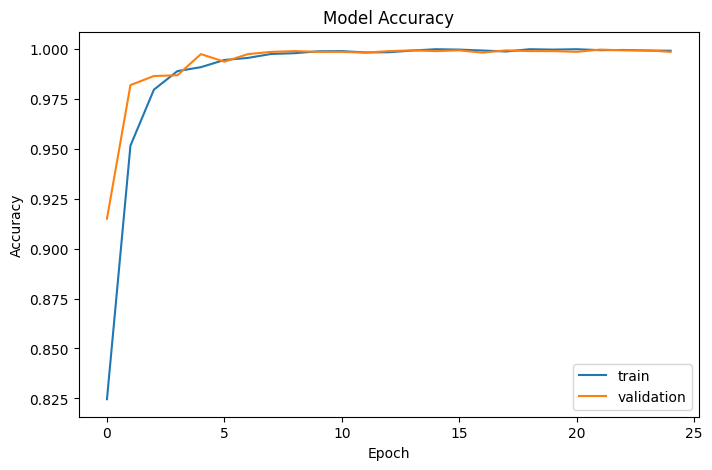

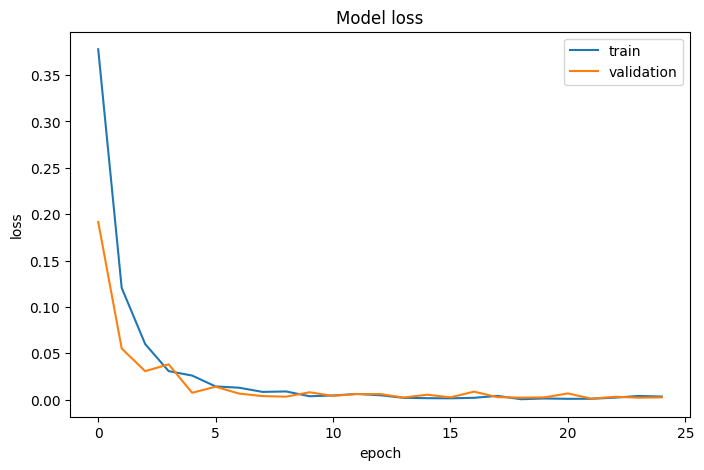

In [20]:
def plot_train_history(history = model_history):
    # Summarize history for accuracy
    plt.figure(figsize = (8, 5))
    #plt.xticks(np.arange(0, 10))
    #plt.yticks(np.arange(0, 100))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

    # Summarize history for loss
    plt.figure(figsize = (8, 5))
    #plt.xticks(np.arange(0, 10))
    #plt.yticks(np.arange(0, 100))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

plot_train_history(model_history)

In [21]:
ypred_valid = model.predict(valid_tensors)

83/83 [==============================] - 2s 18ms/step


In [22]:
ypred_class = np.argmax(ypred_valid,axis=1)
yvalid = np.argmax(yvalid,axis=1)

In [23]:
accuracy = accuracy_score(yvalid, ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(yvalid, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(yvalid,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(yvalid,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
